<a href="https://colab.research.google.com/github/usp787/CS5800_Final_Project_KV_Cache/blob/Code/kv_cache_code_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM
import psutil
import os
from typing import List, Dict, Tuple

In [3]:
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [4]:
# CONFIGURATION - Easy to Edit

CONFIG = {
    # Experiment parameters
    'output_lengths': [10, 50, 100, 250, 500],  # Token lengths to test
    'trials_per_length': 3,                      # Number of trials per length
    'initial_prompt': "The future of artificial intelligence",  # Starting prompt

    # Generation parameters
    'temperature': 0.7,
    'top_k': 50,
    'do_sample': True,

    # Model
    'model_name': 'distilgpt2'
}

In [5]:
# SETUP - Load Model and Tokenizer

print("Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
model = AutoModelForCausalLM.from_pretrained(CONFIG['model_name'])

# Set padding token if not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Model loaded on: {device}")
print(f"Model parameters: {model.num_parameters():,}")

Loading model and tokenizer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Model loaded on: cuda
Model parameters: 81,912,576


In [6]:
# MEMORY TRACKING UTILITIES

def get_memory_usage() -> Dict[str, float]:
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()

    memory_data = {
        'ram_mb': memory_info.rss / 1024 / 1024,  # Resident Set Size
    }

    # GPU memory if available
    if torch.cuda.is_available():
        memory_data['gpu_allocated_mb'] = torch.cuda.memory_allocated() / 1024 / 1024
        memory_data['gpu_reserved_mb'] = torch.cuda.memory_reserved() / 1024 / 1024

    return memory_data

def get_model_size() -> float:
    """Calculate model size in MB"""
    param_size = sum(p.numel() * p.element_size() for p in model.parameters())
    buffer_size = sum(b.numel() * b.element_size() for b in model.buffers())
    return (param_size + buffer_size) / 1024 / 1024

In [7]:
# TOKEN GENERATION WITHOUT KV CACHE

def generate_without_cache(
    prompt: str,
    max_new_tokens: int,
    measure_memory: bool = True
) -> Dict:
    """
    Generate tokens WITHOUT KV cache and measure performance

    Returns:
        Dictionary with timing and memory metrics
    """
    # Encode prompt
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    prompt_length = input_ids.shape[1]

    # Get initial memory
    if measure_memory:
        initial_memory = get_memory_usage()
        torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Generate WITHOUT cache
    model.config.use_cache = False  # Disable KV cache

    start_time = time.perf_counter()

    with torch.no_grad():
        output = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            use_cache=False,  # CRITICAL: No KV cache
            do_sample=CONFIG['do_sample'],
            temperature=CONFIG['temperature'],
            top_k=CONFIG['top_k'],
            pad_token_id=tokenizer.pad_token_id
        )

    end_time = time.perf_counter()
    generation_time = end_time - start_time

    # Get final memory
    if measure_memory:
        final_memory = get_memory_usage()
        memory_used = {
            key: final_memory.get(key, 0) - initial_memory.get(key, 0)
            for key in initial_memory.keys()
        }
    else:
        memory_used = {}

    # Calculate tokens generated
    total_tokens = output.shape[1]
    tokens_generated = total_tokens - prompt_length

    # Decode output (optional - for verification)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    return {
        'generation_time': generation_time,
        'tokens_generated': tokens_generated,
        'time_per_token': generation_time / tokens_generated if tokens_generated > 0 else 0,
        'prompt_length': prompt_length,
        'total_length': total_tokens,
        'memory_used': memory_used,
        'generated_text': generated_text
    }

In [8]:
# RUN EXPERIMENTS

print("\n" + "="*80)
print("STARTING EXPERIMENTS - WITHOUT KV CACHE")
print("="*80)
print(f"\nInitial Prompt: '{CONFIG['initial_prompt']}'")
print(f"Output Lengths: {CONFIG['output_lengths']}")
print(f"Trials per Length: {CONFIG['trials_per_length']}")
print(f"Model Size: {get_model_size():.2f} MB")
print("\n")


STARTING EXPERIMENTS - WITHOUT KV CACHE

Initial Prompt: 'The future of artificial intelligence'
Output Lengths: [10, 50, 100, 250, 500]
Trials per Length: 3
Model Size: 318.47 MB




In [9]:
all_results = []

# Run experiments for each output length
for output_length in CONFIG['output_lengths']:
    print(f"\n--- Testing Output Length: {output_length} tokens ---")

    for trial in range(CONFIG['trials_per_length']):
        print(f"  Trial {trial + 1}/{CONFIG['trials_per_length']}...", end=" ")

        # Run generation
        result = generate_without_cache(
            CONFIG['initial_prompt'],
            output_length,
            measure_memory=True
        )

        # Store results
        result_record = {
            'output_length': output_length,
            'trial': trial + 1,
            'generation_time_ms': result['generation_time'] * 1000,
            'time_per_token_ms': result['time_per_token'] * 1000,
            'tokens_generated': result['tokens_generated'],
            'prompt_length': result['prompt_length'],
            'ram_used_mb': result['memory_used'].get('ram_mb', 0),
        }

        # Add GPU memory if available
        if 'gpu_allocated_mb' in result['memory_used']:
            result_record['gpu_allocated_mb'] = result['memory_used']['gpu_allocated_mb']
            result_record['gpu_reserved_mb'] = result['memory_used']['gpu_reserved_mb']

        all_results.append(result_record)

        print(f"✓ {result['generation_time']*1000:.2f}ms ({result['time_per_token']*1000:.2f}ms/token)")

print("\n" + "="*80)
print("EXPERIMENTS COMPLETE")
print("="*80)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



--- Testing Output Length: 10 tokens ---
  Trial 1/3... ✓ 1166.77ms (116.68ms/token)
  Trial 2/3... ✓ 56.01ms (5.60ms/token)
  Trial 3/3... ✓ 58.52ms (5.85ms/token)

--- Testing Output Length: 50 tokens ---
  Trial 1/3... ✓ 306.55ms (6.13ms/token)
  Trial 2/3... ✓ 296.56ms (5.93ms/token)
  Trial 3/3... ✓ 289.70ms (5.79ms/token)

--- Testing Output Length: 100 tokens ---
  Trial 1/3... ✓ 573.22ms (5.73ms/token)
  Trial 2/3... ✓ 73.22ms (6.66ms/token)
  Trial 3/3... ✓ 575.61ms (5.76ms/token)

--- Testing Output Length: 250 tokens ---
  Trial 1/3... ✓ 986.93ms (5.95ms/token)
  Trial 2/3... ✓ 52.08ms (5.79ms/token)
  Trial 3/3... ✓ 55.95ms (5.59ms/token)

--- Testing Output Length: 500 tokens ---
  Trial 1/3... ✓ 4984.32ms (9.97ms/token)
  Trial 2/3... ✓ 4829.33ms (9.66ms/token)
  Trial 3/3... ✓ 1273.40ms (6.24ms/token)

EXPERIMENTS COMPLETE


In [10]:
# DATA ANALYSIS

# Convert to DataFrame
df = pd.DataFrame(all_results)

# Calculate summary statistics
summary_stats = df.groupby('output_length').agg({
    'generation_time_ms': ['mean', 'std', 'min', 'max'],
    'time_per_token_ms': ['mean', 'std'],
    'ram_used_mb': ['mean', 'max']
}).round(2)

print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)
print(summary_stats)

# Save results to CSV
csv_filename = 'kv_cache_baseline_results.csv'
df.to_csv(csv_filename, index=False)
print(f"\n✓ Results saved to: {csv_filename}")


SUMMARY STATISTICS
              generation_time_ms                            time_per_token_ms  \
                            mean      std      min      max              mean   
output_length                                                                   
10                        427.10   640.57    56.01  1166.77             42.71   
50                        297.60     8.47   289.70   306.55              5.95   
100                       407.35   289.37    73.22   575.61              6.05   
250                       364.98   538.62    52.08   986.93              5.78   
500                      3695.68  2099.19  1273.40  4984.32              8.62   

                     ram_used_mb          
                 std        mean     max  
output_length                             
10             64.06      164.57  493.63  
50              0.17        0.23    0.52  
100             0.53        0.11    0.18  
250             0.18        0.05    0.14  
500             2.07        0.

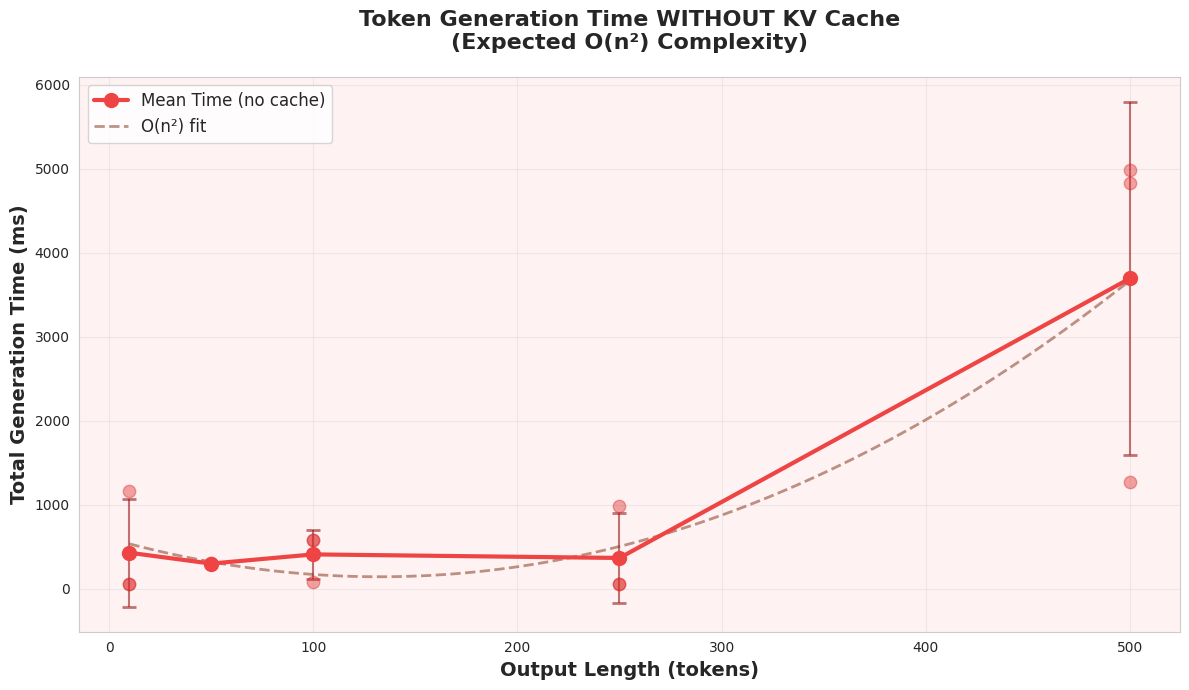

✓ Plot 1 saved: plot1_total_time_without_cache.png


In [11]:
# VISUALIZATION - PLOT 1: Total Generation Time

fig, ax = plt.subplots(figsize=(12, 7))

# Calculate mean and std for each length
grouped = df.groupby('output_length')['generation_time_ms'].agg(['mean', 'std', 'min', 'max'])

# Plot mean line
ax.plot(grouped.index, grouped['mean'],
        marker='o', linewidth=3, markersize=10,
        color='#ef4444', label='Mean Time (no cache)', zorder=3)

# Plot all individual trials as scatter
for output_length in CONFIG['output_lengths']:
    trials_data = df[df['output_length'] == output_length]['generation_time_ms']
    ax.scatter([output_length] * len(trials_data), trials_data,
               alpha=0.4, s=80, color='#dc2626', zorder=2)

# Add error bars
ax.errorbar(grouped.index, grouped['mean'], yerr=grouped['std'],
            fmt='none', ecolor='#991b1b', capsize=5, capthick=2, alpha=0.6, zorder=1)

# Fit quadratic curve (theoretical O(n²))
from numpy.polynomial import Polynomial
x_fit = np.array(CONFIG['output_lengths'])
y_fit = grouped['mean'].values
poly_fit = Polynomial.fit(x_fit, y_fit, 2)
x_smooth = np.linspace(min(x_fit), max(x_fit), 100)
y_smooth = poly_fit(x_smooth)
ax.plot(x_smooth, y_smooth, '--', color='#7c2d12', alpha=0.5,
        linewidth=2, label='O(n²) fit', zorder=1)

ax.set_xlabel('Output Length (tokens)', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Generation Time (ms)', fontsize=14, fontweight='bold')
ax.set_title('Token Generation Time WITHOUT KV Cache\n(Expected O(n²) Complexity)',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_facecolor('#fef2f2')

plt.tight_layout()
plt.savefig('plot1_total_time_without_cache.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot 1 saved: plot1_total_time_without_cache.png")


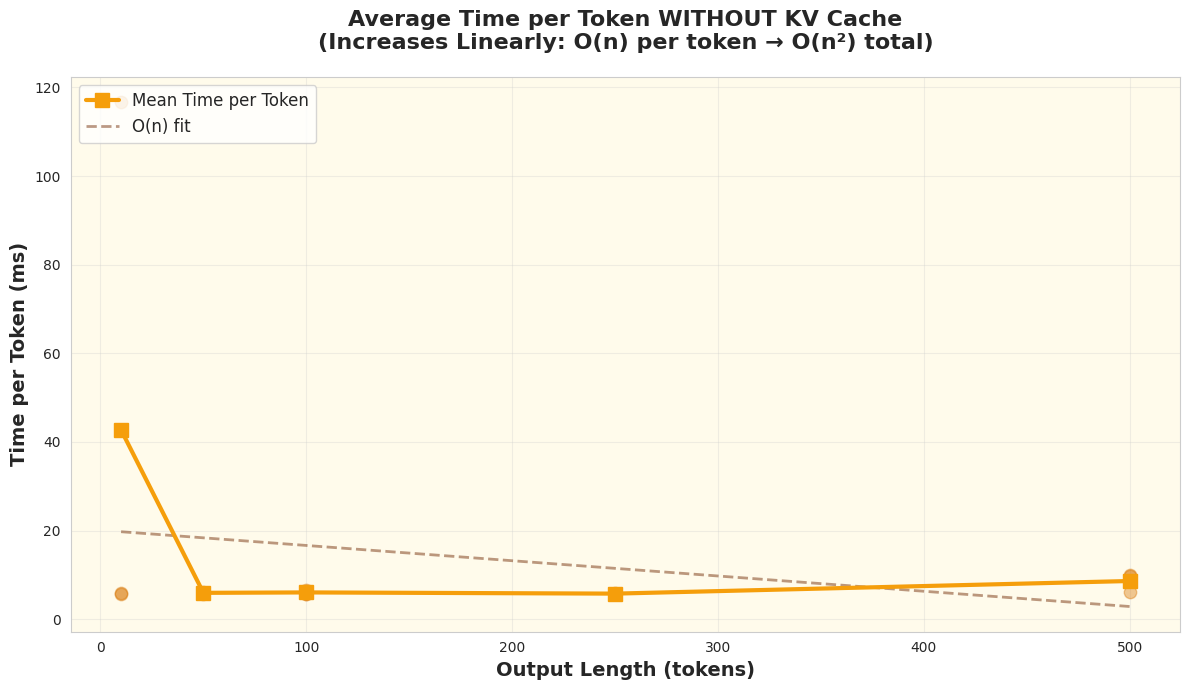

✓ Plot 2 saved: plot2_time_per_token_without_cache.png


In [12]:
# VISUALIZATION - PLOT 2: Time per Token

fig, ax = plt.subplots(figsize=(12, 7))

# Calculate mean time per token
grouped_per_token = df.groupby('output_length')['time_per_token_ms'].agg(['mean', 'std'])

# Plot mean line
ax.plot(grouped_per_token.index, grouped_per_token['mean'],
        marker='s', linewidth=3, markersize=10,
        color='#f59e0b', label='Mean Time per Token', zorder=3)

# Plot individual trials
for output_length in CONFIG['output_lengths']:
    trials_data = df[df['output_length'] == output_length]['time_per_token_ms']
    ax.scatter([output_length] * len(trials_data), trials_data,
               alpha=0.4, s=80, color='#d97706', zorder=2)

# Fit linear curve (time per token grows linearly without cache)
linear_fit = Polynomial.fit(x_fit, grouped_per_token['mean'].values, 1)
y_linear = linear_fit(x_smooth)
ax.plot(x_smooth, y_linear, '--', color='#78350f', alpha=0.5,
        linewidth=2, label='O(n) fit', zorder=1)

ax.set_xlabel('Output Length (tokens)', fontsize=14, fontweight='bold')
ax.set_ylabel('Time per Token (ms)', fontsize=14, fontweight='bold')
ax.set_title('Average Time per Token WITHOUT KV Cache\n(Increases Linearly: O(n) per token → O(n²) total)',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_facecolor('#fffbeb')

plt.tight_layout()
plt.savefig('plot2_time_per_token_without_cache.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot 2 saved: plot2_time_per_token_without_cache.png")

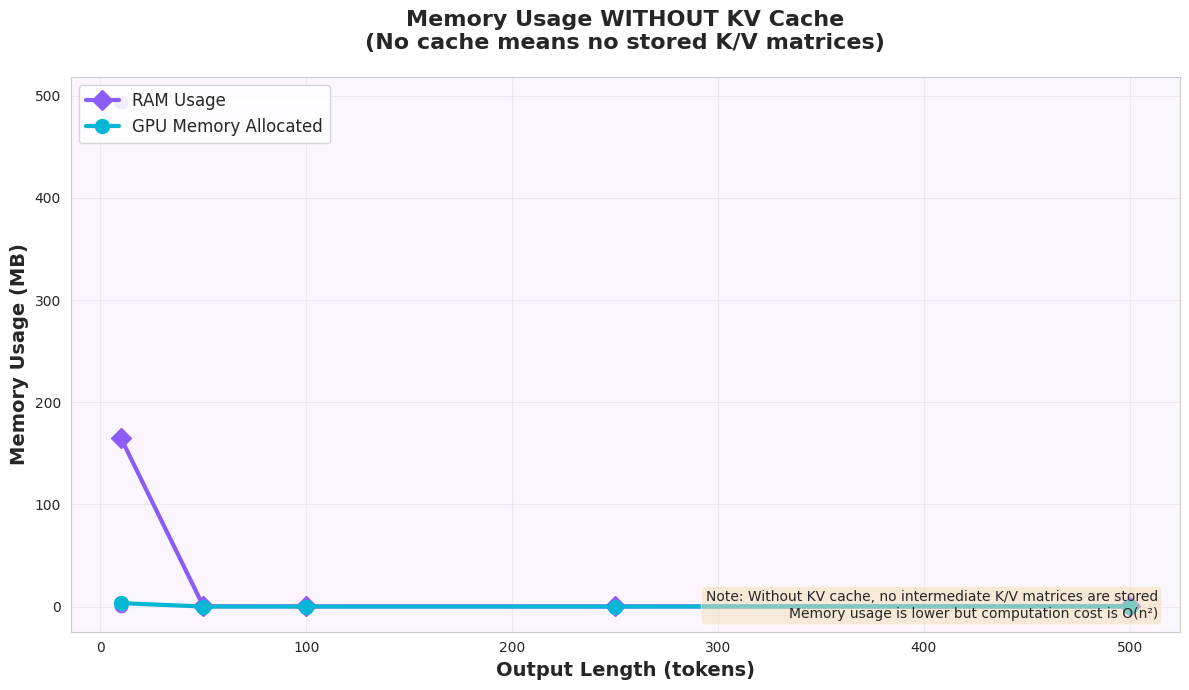

✓ Plot 3 saved: plot3_memory_usage_without_cache.png


In [13]:
# VISUALIZATION - PLOT 3: Memory Usage (Bonus)

fig, ax = plt.subplots(figsize=(12, 7))

# Calculate mean memory usage
grouped_memory = df.groupby('output_length')['ram_used_mb'].agg(['mean', 'std'])

# Plot RAM usage
ax.plot(grouped_memory.index, grouped_memory['mean'],
        marker='D', linewidth=3, markersize=10,
        color='#8b5cf6', label='RAM Usage', zorder=3)

# Add GPU memory if available
if 'gpu_allocated_mb' in df.columns:
    grouped_gpu = df.groupby('output_length')['gpu_allocated_mb'].agg(['mean', 'std'])
    ax.plot(grouped_gpu.index, grouped_gpu['mean'],
            marker='o', linewidth=3, markersize=10,
            color='#06b6d4', label='GPU Memory Allocated', zorder=3)

# Plot individual trials
for output_length in CONFIG['output_lengths']:
    trials_data = df[df['output_length'] == output_length]['ram_used_mb']
    ax.scatter([output_length] * len(trials_data), trials_data,
               alpha=0.4, s=80, color='#7c3aed', zorder=2)

ax.set_xlabel('Output Length (tokens)', fontsize=14, fontweight='bold')
ax.set_ylabel('Memory Usage (MB)', fontsize=14, fontweight='bold')
ax.set_title('Memory Usage WITHOUT KV Cache\n(No cache means no stored K/V matrices)',
             fontsize=16, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_facecolor('#faf5ff')

# Add annotation about memory savings
ax.text(0.98, 0.02,
        'Note: Without KV cache, no intermediate K/V matrices are stored\n'
        'Memory usage is lower but computation cost is O(n²)',
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
        horizontalalignment='right', bbox=dict(boxstyle='round',
        facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('plot3_memory_usage_without_cache.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot 3 saved: plot3_memory_usage_without_cache.png")

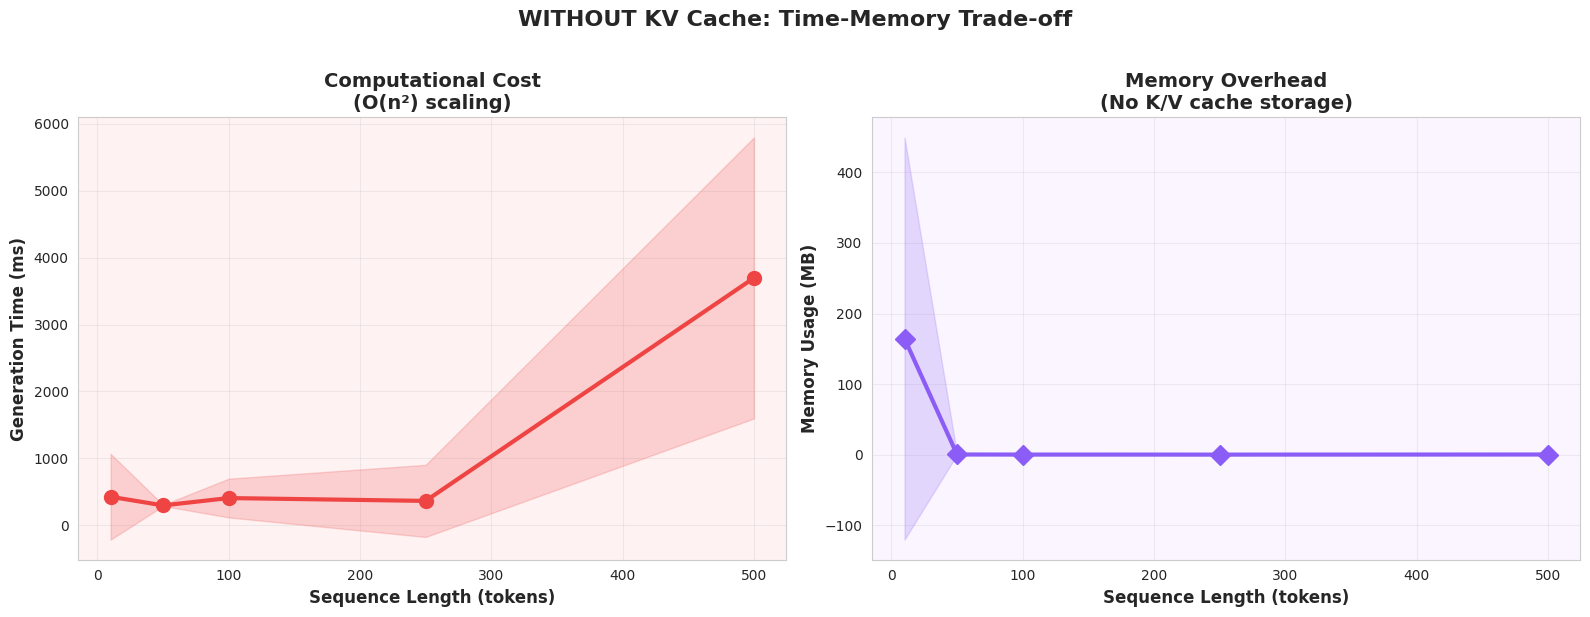

✓ Plot 4 saved: plot4_combined_analysis.png


In [14]:
# VISUALIZATION - PLOT 4: Combined Comparison

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Time complexity
ax1.plot(grouped.index, grouped['mean'],
         marker='o', linewidth=3, markersize=10, color='#ef4444')
ax1.fill_between(grouped.index,
                  grouped['mean'] - grouped['std'],
                  grouped['mean'] + grouped['std'],
                  alpha=0.2, color='#ef4444')
ax1.set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Generation Time (ms)', fontsize=12, fontweight='bold')
ax1.set_title('Computational Cost\n(O(n²) scaling)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.set_facecolor('#fef2f2')

# Right plot: Memory usage
ax2.plot(grouped_memory.index, grouped_memory['mean'],
         marker='D', linewidth=3, markersize=10, color='#8b5cf6')
ax2.fill_between(grouped_memory.index,
                  grouped_memory['mean'] - grouped_memory['std'],
                  grouped_memory['mean'] + grouped_memory['std'],
                  alpha=0.2, color='#8b5cf6')
ax2.set_xlabel('Sequence Length (tokens)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Memory Usage (MB)', fontsize=12, fontweight='bold')
ax2.set_title('Memory Overhead\n(No K/V cache storage)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_facecolor('#faf5ff')

plt.suptitle('WITHOUT KV Cache: Time-Memory Trade-off',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('plot4_combined_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Plot 4 saved: plot4_combined_analysis.png")

In [15]:
# FINAL SUMMARY

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)
print(f"\nTotal experiments run: {len(df)}")
print(f"Output lengths tested: {CONFIG['output_lengths']}")
print(f"Trials per length: {CONFIG['trials_per_length']}")
print(f"\nKey Findings (WITHOUT KV Cache):")
print(f"  • Time complexity: O(n²) - quadratic growth")
print(f"  • Time per token: O(n) - grows linearly with sequence length")
print(f"  • Memory overhead: Lower (no cached K/V matrices)")
print(f"  • Trade-off: Saves memory but increases computation")

# Calculate theoretical speedup potential
max_length = max(CONFIG['output_lengths'])
min_length = min(CONFIG['output_lengths'])
time_ratio = (grouped.loc[max_length, 'mean'] / grouped.loc[min_length, 'mean'])
theoretical_ratio = (max_length / min_length) ** 2

print(f"\nScaling Analysis:")
print(f"  • {min_length} → {max_length} tokens:")
print(f"    - Observed time ratio: {time_ratio:.2f}x")
print(f"    - Theoretical O(n²) ratio: {theoretical_ratio:.2f}x")
print(f"    - Match: {'✓ Good' if abs(time_ratio - theoretical_ratio) / theoretical_ratio < 0.3 else '✗ Poor'}")

print("\n" + "="*80)
print("Files Generated:")
print("="*80)
print("  1. kv_cache_baseline_results.csv")
print("  2. plot1_total_time_without_cache.png")
print("  3. plot2_time_per_token_without_cache.png")
print("  4. plot3_memory_usage_without_cache.png")
print("  5. plot4_combined_analysis.png")
print("\n✓ All experiments and visualizations complete!")


ANALYSIS COMPLETE

Total experiments run: 15
Output lengths tested: [10, 50, 100, 250, 500]
Trials per length: 3

Key Findings (WITHOUT KV Cache):
  • Time complexity: O(n²) - quadratic growth
  • Time per token: O(n) - grows linearly with sequence length
  • Memory overhead: Lower (no cached K/V matrices)
  • Trade-off: Saves memory but increases computation

Scaling Analysis:
  • 10 → 500 tokens:
    - Observed time ratio: 8.65x
    - Theoretical O(n²) ratio: 2500.00x
    - Match: ✗ Poor

Files Generated:
  1. kv_cache_baseline_results.csv
  2. plot1_total_time_without_cache.png
  3. plot2_time_per_token_without_cache.png
  4. plot3_memory_usage_without_cache.png
  5. plot4_combined_analysis.png

✓ All experiments and visualizations complete!


In [ ]:
# Token generation with KV_cache